## Simple DQN implimentation on Cartpole environment using neural networks

In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
#hyper parameters
GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 50000
BATCH_SIZE = 32

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.05
EXPLORATION_DECAY = 0.995

In [3]:
class DeepQNetwort:
    def __init__(self, obervation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX
        self.action_space = action_space
        
        # memory for experience replay
        self.memory = deque(maxlen=MEMORY_SIZE)
        
        #model creation
        self.model = Sequential()
        self.model.add(Dense(12, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(12, activation="relu"))
        self.model.add(Dense(12, activation="relu"))
        self.model.add(Dense(action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.hist = None
        #self.reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, min_lr=0.0001)
        #self.tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, update_freq=32768)
        #self.checkpoint = ModelCheckpoint("model.h5", monitor="loss", verbose=0, save_best_only=True, mode="min")
    
    def remember(self, state, action, reward, next_state, done):
        # add new experience to the memory
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # if gemerated number less than exploration rate, take random action
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        # else take action according to the qvalue
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
    
    def experience_replay(self):
        # check if there are enough memories for experience replay
        if len(self.memory) < BATCH_SIZE:
            return
        
        # sample random experiences from the memories
        batch = random.sample(self.memory, BATCH_SIZE)
        
        for state, action, reward, state_next, done in batch:
            if done:
                # if game ended the best qvalue can only be reward at current state
                q_update = reward
            else:
                # estimate better qvalue for the give s,a using bellman equation
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            # qval predicted by model
            q_values = self.model.predict(state)
            # update only the predicted qvalue of the given s,a using the better qvalue
            q_values[0][action] = q_update
            # fit into the model
            self.hist = self.model.fit(state, q_values, epochs=1,verbose=0)#, callbacks=[self.reduce_lr], self.tensorboard, self.checkpoint]
        
        # decay the exploration rate
        if self.exploration_rate >  EXPLORATION_MIN:
            self.exploration_rate *= EXPLORATION_DECAY

In [4]:
env = gym.make('CartPole-v1')
done = False
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
observation = env.reset()
reward = 0
scores = []

network = DeepQNetwort(observation_space, action_space)

for episode in range(500):
    # reset environent at the start of each episode
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    done = False
    reward = 0
    step = 0
    while True:
        step += 1
        # take an action
        action = network.act(state)
        # get results of that action
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, observation_space])
        reward = reward if not done else -reward
        # store this experience into memory
        network.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("\rEpisode:", episode,", score:" ,step, end="")
            scores.append(step)
            break
        # do experince replay
        network.experience_replay()
env.close()

Instructions for updating:
Colocations handled automatically by placer.
Episode: 1 , score: 12WARNING:tensorflow:From C:\Users\BME-3\Anaconda3\envs\rl\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Episode: 499 , score: 895

In [16]:
# save the model
from joblib import dump, load 
dump(scores, 'scores.joblib') 
network.model.save('model.hdf5')

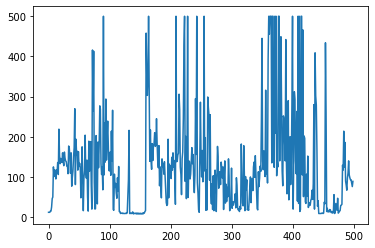

In [9]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [3]:
# watch the agent play game
env = gym.make('CartPole-v1')
done = False
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
reward = 0
# trained for 500 episodes
qnetwork = load_model('models/model_cartpole.hdf5')
for episode in range(10):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    done = False
    reward = 0
    step = 0
    while True:
        step += 1
        env.render()
        action = np.argmax(qnetwork.predict(state))
        state, reward, done, info = env.step(action)
        state = np.reshape(state, [1, observation_space])
        if done:
            print("\rEpisode:", episode,", score:" ,step, end="")
            break
env.close()

Episode: 9 , score: 500